In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt

## 1.数据集
采用Auto MPG数据集，记录了各种汽车效能指标与气缸数据、重量、马力等真实数据<br>
查看数据集的前5项如下：

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch06-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/img/13.png?raw=true)

除了产地的数字字段表示类别外，其他字段都是数值类型。对于产地字段，1表示美国，2表示欧洲，3表示日本：

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch06-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/img/14.png?raw=true)

Auto MPG数据集义工记录了398项数据，从[UCI服务器](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data)下载并读取到DataFrame对象中：

### 1.1.加载数据集

In [2]:
from tensorflow import keras
import pandas as pd
import os
# dataset_path=keras.utils.get_file('auto-mpg.data','file://'+os.path.abspath('./data/auto-mpg.data'))
# 下载汽车效能数据集
dataset_path=keras.utils.get_file('auto-mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
print(dataset_path)
# 利用pandas读取数据集
column_names=['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
raw_dataset=pd.read_csv(dataset_path,names=column_names,na_values='?',comment='\t',sep=" ",skipinitialspace=True)
dataset=raw_dataset.copy()
# 查看部分数据
print(dataset.head())

/home/julian/.keras/datasets/auto-mpg.data
    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  


### 1.2.清除空白数据
删除含有空白字段的数据样本

In [3]:
# 删除空字段数据项（含有空字段的行）
print(dataset.isna().sum()) # 统计空白行
dataset=dataset.dropna() # 删除空白数据项
print(dataset.isna().sum()) # 再次统计空白行

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


### 1.3.字段类型处理
由于Origin字段为类别类型数据，先将其移除，转换为新的3个字段：USA、Europe、Japan：


In [4]:
# 先弹出（删除并返回）origin这一列
origin=dataset.pop('Origin')
# 根据origin列来写入新的3个列
dataset['USA']=(origin==1)*1.0
dataset['Europe']=(origin==2)*1.0
dataset['Japan']=(origin==3)*1.0
print(dataset.tail()) # 查看表格后几项

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0  


#### 1.3.1 数据集特征分布观测
如下图示，可以大致观察到汽车排量、重量与MPG的关系比较简单, 随着排量或重量的增大，汽车的MPG降低，能耗增加；气缸数越小，汽车能做到的最好MPG也越高，越可能更节能，这都是是符合我们的生活经验的。

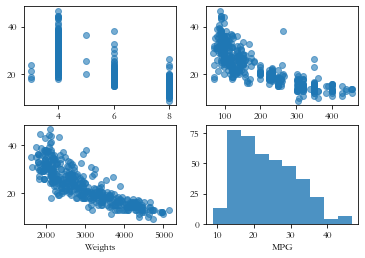

In [5]:
cylinders=dataset['Cylinders']
displacements=dataset['Displacement']
weights=dataset['Weight']
MPGs=dataset['MPG']

plt.subplot(2,2,1)
plt.scatter(cylinders,MPGs,alpha=0.6)
plt.xlabel('Cylinders')

plt.subplot(2,2,2)
plt.scatter(displacements,MPGs,alpha=0.6)
plt.xlabel('Displacement')

plt.subplot(2,2,3)
plt.scatter(weights,MPGs,alpha=0.6)
plt.xlabel('Weights')

plt.subplot(2,2,4)
plt.hist(MPGs,alpha=0.8)
plt.xlabel('MPG')

plt.show()

### 1.4.划分数据集
按照8:2比例划分训练/测试集

In [6]:
train_dataset=dataset.sample(frac=.8,random_state=0)
test_dataset=dataset.drop(train_dataset.index)

将MPG字段作为标签，因此从train_dataset/test_dataset中移出

In [7]:
train_labels=train_dataset.pop('MPG')
test_labels=test_dataset.pop('MPG')

### 1.5.数据标准化
统计训练集的各个字段的均值和标准差，并完成数据的标准化

In [8]:
# 查看训练集的输入X的统计数据
train_stats=train_dataset.describe()
# print(train_stats)
import sys
try:
    train_stats.pop('MPG')
    # print(train_stats)
except Exception:
    pass
# 标准化数据
def norm(x,stats):
    '''
    标准化，减去每个字段的均值，并除以标准差
    :param x:
    :return:
    '''
    return (x-stats.loc['mean'])/stats.loc['std']
normed_train_data=norm(train_dataset,train_stats) # 标准化训练集
normed_test_data=norm(test_dataset,train_stats) # 标准化测试集
print(normed_train_data.shape)
print(normed_test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(314, 9)
(78, 9)
(314,)
(78,)


### 1.6.构建数据集对象
利用切分的训练集数据构建数据集对象：

In [9]:
train_db=tf.data.Dataset.from_tensor_slices(
    (normed_train_data.values,train_labels.values)) # 构建Dataset对象
train_db=train_db.shuffle(100).batch(32) # 随机打散，批量化

## 2.创建网络

考虑到Auto MPG数据集规模较小，我们只创建一个3层的全连接网络来完成MPG值的预测任务。<br>
* 输入X的特征共有9种，因此第一层的输入节点数为9。
* 第一层和第二层的输出节点数设计为64和64，由于只有一种预测值，输出层输出节点设计为1。
* 由于MPG$\in R^+$，因此输出层的激活函数可以不加，也可以添加ReLU激活函数。

### 2.1.设计自定义网络类

将网络实现为一个自定义网络类，只需要在初始化函数中创建各个子网络层，并在前向计算函数call中实现自定义网络类的计算逻辑即可。<br>
自定义网络类继承自`keras.Model`基类，这也是自定义网络的标准写法，以方便利用其提供的`trainable_variables`、`save_weights`等各种便捷功能。

In [10]:
class Network(keras.Model):
    '''
    回归网络模型
    '''
    def __init__(self):
        super(Network,self).__init__()
        # 创建3个全连接层
        self.fc1=keras.layers.Dense(64,activation='relu')
        self.fc2=keras.layers.Dense(64,activation='relu')
        self.fc3=keras.layers.Dense(1)
    def call(self,inputs,training=None,mask=None):
        # 依次通过3个全连接层
        x=self.fc1(inputs)
        x=self.fc2(x)
        x=self.fc3(x)

        return x

## 3.训练与测试

### 3.1.实例化网络并创建优化器

在完成主网络模型类的创建后，实例化网络对象和创建优化器，如下：

In [11]:
model=Network() # 创建网络类实例
# 通过build函数完成内部张量的创建，其中4为任意设置的batch数量，9为输入特征长度
model.build(input_shape=(4,9))
model.summary() # 打印网络信息
optimizer=keras.optimizers.RMSprop(0.001) # 创建优化器，指定学习率

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  640       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### 3.2.循环训练

通过Epoch和Step组成双层嵌套循环：

In [12]:
train_mses=[]
train_maes=[]
test_mses=[]
test_maes=[]
for epoch in range(100): # 200个Epoch
    for step,(x,y) in enumerate(train_db): # 遍历一次
        x=tf.cast(x,dtype=tf.float32)
        y=tf.cast(y,dtype=tf.float32)
        # 梯度记录器
        with tf.GradientTape() as tape:
            out=model(x) # 通过网络获得输出
            each_loss=keras.losses.MSE(y,out) # 计算batch里的每个样本的MSE
            mean_mse_loss=tf.reduce_mean(each_loss) # 计算batch里的样本的平均MSE loss
            mean_mae_loss=tf.reduce_mean(keras.losses.MAE(y,out)) # 计算样本平均 MAE loss
        if step % 5==0:
            print(f'epoch[{epoch}]-step[{step}] loss:{float(mean_mse_loss)}')
        grads=tape.gradient(mean_mse_loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables)) # 此处可对比a05.08的写法，有何不同？

    train_mses.append(mean_mse_loss)
    train_maes.append(mean_mae_loss)
    # 使用测试集验证
    test_out=model(tf.constant(normed_test_data.values))
    test_mses.append(tf.reduce_mean(keras.losses.MSE(test_labels,out)))
    test_maes.append(tf.reduce_mean(keras.losses.MAE(test_labels,out)))

epoch[0]-step[0] loss:682.953857421875
epoch[0]-step[5] loss:550.34765625

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch[1]-step[0] loss:555.0595092773438
epoch[1]-step[5] loss:438.30511474609375
epoch[2]-step[0] loss:550.3174438476562
epoch[2]-step[5] loss:427.8591613769531
epoch[3]-step[0] loss:386.0423278808594
epoch[3]-step[5] loss:358.02618408203125
epoch[4]-step[0] loss:324.1351623535156
epoch[4]-step[5] loss:329.95172119140625
epoch[5]-step[0] loss:189.56573486328125
epoch[5]-step[5] loss:225.66921997070312
epoch[6]-step[0] loss:192.308

对于回归问题，不仅可用MSE来测试模型性能，也可用平均绝对误差(Mean Absolute Error)MAE来衡量模型性能：

${\rm mae}\triangleq\frac1{d_{\rm out}}\sum_i|y_i-o_i|$

此处考虑用MSE来更新训练参数，用MSE和MAE来观测模型性能：

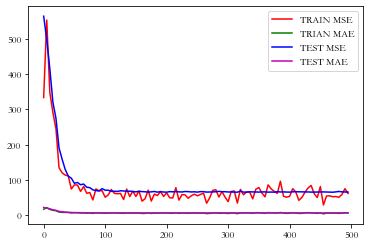

In [13]:
xaxis=[i*5 for i in range(len(train_maes))]
plt.plot(xaxis,train_mses,color='r',label='TRAIN MSE')
plt.plot(xaxis,train_maes,color='g',label='TRIAN MAE')
plt.plot(xaxis,test_mses,color='b',label='TEST MSE')
plt.plot(xaxis,test_maes,color='m',label='TEST MAE')
plt.legend()
plt.show()

In [ ]:
import os
pid=os.getpid()
!kill -9 $pid


